# Social Representations and Boundaries of Humor: A focus on Gender roles

## Research questions: 

1) How are men and women depicted in New Yorker cartoons and captions, and do these depictions reflect traditional gender roles or stereotypes?

2) How does audience response (e.g., votes or winning captions) relate to gendered content—do captions about one gender receive more positive attention ?

## Structure:

### 0. Method to detect gender

Detect gendered references in captions/descriptions and assign a gender to each of them (male, female, both, neutral). 

*Method*: Found two gender lists that contains gendered word. I wanted a longer list so I manually augmented it with universal gendered word and contextual gender markers. Then I added words based on what words are actually on the dataset.

### 1. General distributions

1) Overall presence of gender in captions and image descriptions (barplot)

2) Plot to see overall evolution over time

### 2. How are men/women depicted in the captions

1) Find the top words associated with each gender (wordclouds)

2) Find topic related to man and woman (topic detection)

3) Are men/women seen positively/negatively? (Does it evolve over time?) (sentiment analysis)


### 3. Audience response to gender related captions ?

1. Are captions mentionning gender more funny ? (funnyness score + t-test: $H_0$: There are no difference in funiness between gendered caption and non gendered captions. If refuted: $H_0$: There are no difference in funiness between male gendered caption and female gendered caption. *hope it's refuted*)

2. Does it change over time ?

## Initialisation of the root path

In [1]:
%matplotlib inline

In [1]:
from pathlib import Path
import sys

def warning1(text): print("WARNING!!! ", text)
ACTIVATE_PRINTS = False

# Get correct root path
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if all((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

if ACTIVATE_PRINTS: print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print(root)

d:\GitHub\ada-2025-project-adacore42


## Imports

In [2]:
# working librairies
import os
import pickle
import csv

sys.path.append(os.path.abspath(".."))

# utils
from src.utils.general_utils import *

# class with functions
from src.models.gender_analysis import GenderAnalysis

# basics
import pandas as pd
import numpy as np

# other
from collections import Counter

# plots
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import plotly.express as px

# text processing libraries
import nltk
import spacy
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Statistical testing
from scipy.stats import mannwhitneyu

In [3]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py

D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\src\data\DataPreparation.py


In [5]:
%run {DATA_PREPARATION_PY_PATH.resolve()}

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,1.73
5,"Sorry for the inconvenience, I probably should...",1.593750,0.117598,32,16,13,3,1.69
6,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52
7,I've decided to take it lying down.,1.593750,0.133647,32,18,9,5,1.26
8,You probably know my column: Man on the Street.,1.538462,0.126865,26,14,10,2,0.89
9,I should have jumped from a higher floor.,1.541667,0.134315,24,13,9,2,0.87


## Loading the data



In [5]:
ga = GenderAnalysis()

In [6]:
data = ga.load_pickle(root / STORED_DATAPREP_PKL_PATH)

In [7]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [8]:
dataA_removed, dataC_removed = drop_NaN(dataA, dataC)

In [9]:
print(f"Length dataA: {len(dataA_removed)}\nShape dataC: {dataC_removed.shape}")

Length dataA: 240
Shape dataC: (240, 9)


In [10]:
dataA_removed[0].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,1.73


In [11]:
dataC_removed.head()

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,contest_id,date
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],510,NaT
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,511,NaT
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",512,2016-03-21
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,513,2016-03-27
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],514,2016-04-03


## Step 0: Augment the gendered lists

Include male and female names: asked to chatGPT to produce me a list (based on Social Security Administration data)

Include public figures: asked chatGPT for 50 male and female celebrities

The list can be found in gender_analysis.py

## Step 1: Detect gender

Use gender lexicons, but we need to define them first. 

For P2, I used two small lists with common gendered terms. For P3 I want to extend them based on what what terms are used in the contest!

### In the image description

In [12]:
# detect gender in the cartoon descriptions
dataC0 = dataC_removed.copy(deep=True)
dataC1 = ga.get_metadata(dataC0)

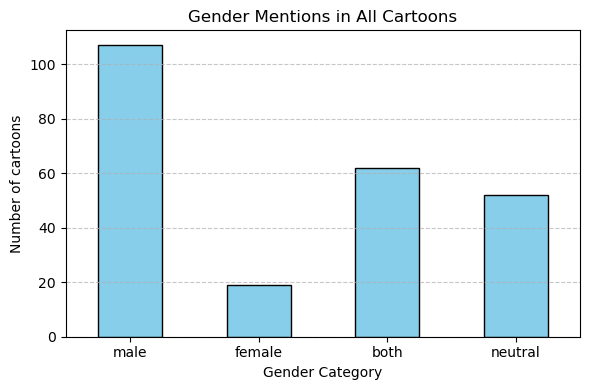

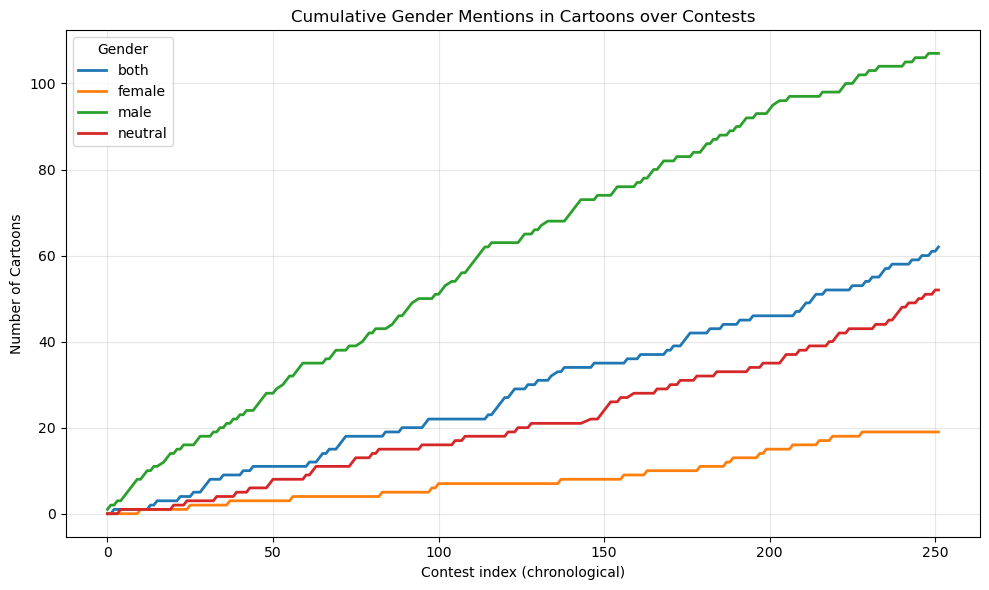

In [13]:
## How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender"
)

In [77]:
list_id = dataC1[dataC1['gender_mention'] == 'both']['contest_id'].values

In [110]:
i = 15
print(list_id[i])
plot_cartoon(list_id[i], root)
index = dataC[dataC['contest_id'] == list_id[i]].index[0]
dataA[index].caption.values[0]

582


'Yes, I see the train but I think we can beat it.'

### In the captions

In [ ]:
# # DON'T RUN THIS AGAIN
# dataTop = ga.get_Top_captions(dataA_removed)

# # Results were saved here: 
# STORED_DATAPREP_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
# with open(STORED_DATAPREP_PKL_PATH, "wb") as f:
#     pickle.dump(dataTop, f)

In [ ]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [11]:
count = []

for idx, contest in enumerate(data_caption):
    # Count mentions per contest
    gender_counts = (
        contest["gender_mention"]
        .value_counts()
        #.unstack(fill_value=0)
        .reset_index()
    )
    count.append(gender_counts)

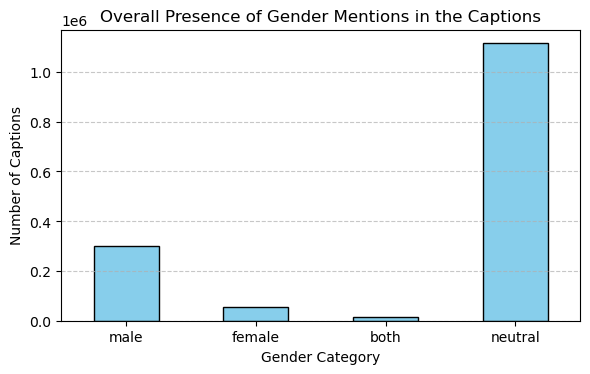

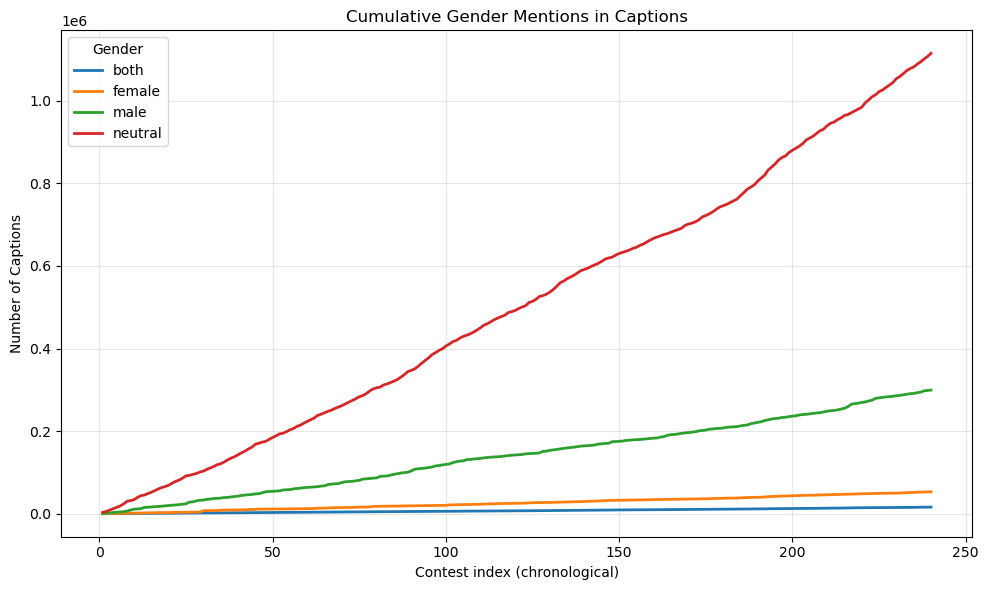

In [12]:
# How often men/women are mentionned in captions

overall_counts, pivoted = ga.distribution_captions(count)

# In the plots I don't show the neutral, because it is a huge number compared
# to the other categories

# Plot Overall counts
ga.plot_overall_counts(
    overall_counts,
    title="Overall Presence of Gender Mentions in the Captions",
    xlabel="Gender Category",
    ylabel="Number of Captions",
    neutral = True
)

# Evolution over time
cumulative = pivoted.cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    cumulative,
    title="Cumulative Gender Mentions in Captions",
    xlabel="Contest index (chronological)",
    ylabel="Number of Captions",
    legend_title="Gender",
    neutral = True
)

## Step 2: How are men/women depicted in the captions ? 

### Verbs and adjectives associated with genders

**METHOD**

1) Using the men and women dictionnaries, I iterated through the contests and counted the occurence of verbs and adjectives in men and women labeled captions.
2) Created wordclouds to show the results

The commented code shows the pipeline used to associate verbs and adjectives to each gender.

In [ ]:
# nlp = spacy.load("en_core_web_sm")

# verbs_male = Counter()
# verbs_female = Counter()
# adjs_male = Counter()
# adjs_female = Counter()

# for contest in data_caption:

#     male_caps   = contest.loc[contest['gender_mention'] == 'male',   'caption'].tolist()
#     female_caps = contest.loc[contest['gender_mention'] == 'female', 'caption'].tolist()

#     # process male captions in batch
#     for doc in nlp.pipe(male_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_male[token.lemma_] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_male[token.lemma_] += 1

#     # process female captions in batch
#     for doc in nlp.pipe(female_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_female[token.lemma_.lower()] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_female[token.lemma_.lower()] += 1

In [ ]:
# STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
# with open(STORED_FREQS_PKL_PATH, "wb") as f:
#     pickle.dump({"verbs_male": verbs_male, "verbs_female": verbs_female, "adjs_male": adjs_male, "adjs_female": adjs_female}, f)

#### Visualisation

In [5]:
ga = GenderAnalysis()

In [6]:
STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
data_wordcloud = ga.load_pickle(STORED_FREQS_PKL_PATH)

verbs_male = data_wordcloud['verbs_male']
verbs_female = data_wordcloud['verbs_female']

adjs_male = data_wordcloud['adjs_male']
adjs_female = data_wordcloud['adjs_female']

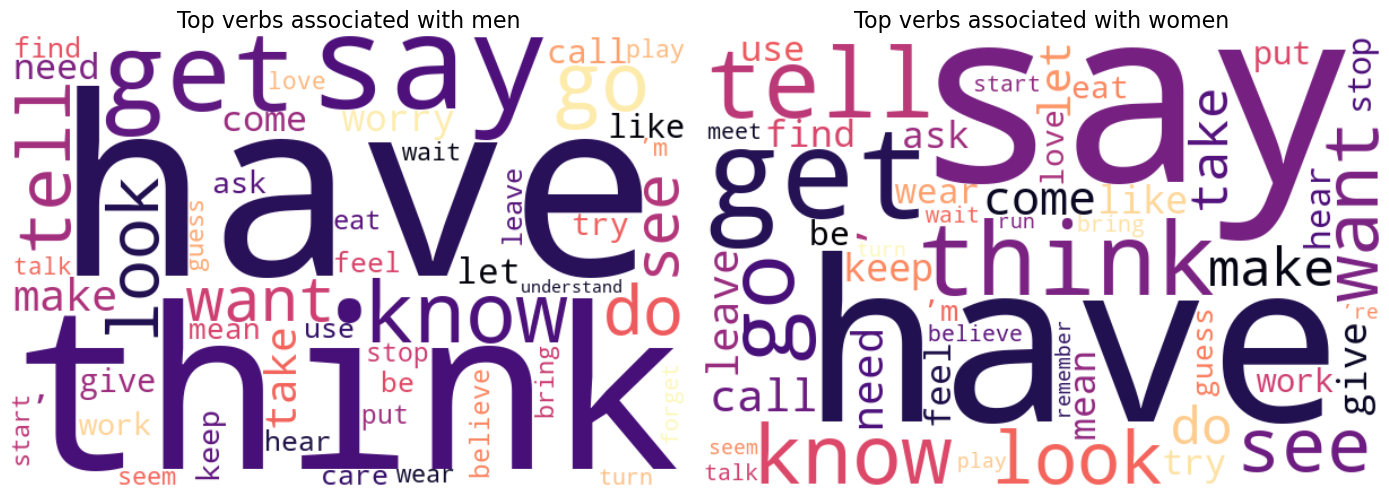

In [7]:
# --- Generate the word clouds - VERB ---
male_cloud_verb = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_male)

female_cloud_verb = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_female)

ga.plot_wordclouds(male_cloud_verb, female_cloud_verb, 'verbs')

# size indicates frequency, color is just for esthetics

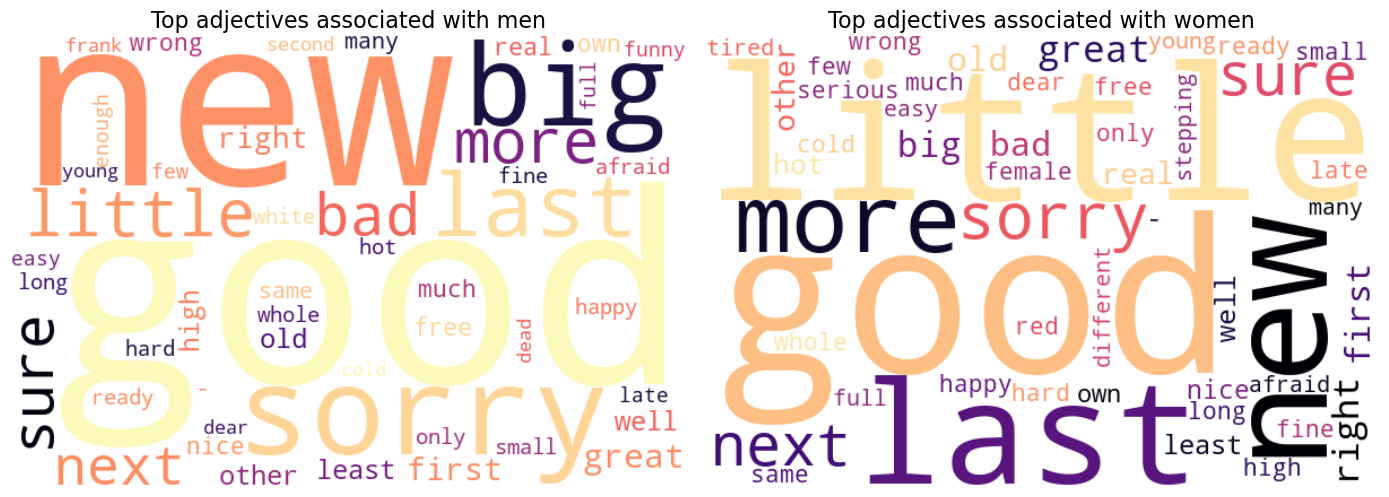

In [8]:
# --- Generate the word clouds - ADJ ---
male_cloud_adj = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_male)

female_cloud_adj = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_female)

ga.plot_wordclouds(male_cloud_adj, female_cloud_adj, 'adjectives')

In [9]:
# STORED_WORDCLOUD_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\wordcloud.pkl'
# with open(STORED_WORDCLOUD_PKL_PATH, "wb") as f:
#     pickle.dump({"male_adj": male_cloud_adj, "female_adj": female_cloud_adj, "male_verb": male_cloud_verb, "female_verb": female_cloud_verb}, f)

#### Comments **TO ADD**

### Topic modelling

**METHOD**

1) Run BERTopic for each gender. (Since my computer is weak and that I have over 300k captions gendered as male, I had to run BERTopic four separate times.)
2) Aggregate the topic from BERTopic to comprehensive ones. The dictionnaries of this are stored in src\models\gender_analysis.py.
3) Handle the unbalance: Since we have an umbalance in the number of captions for each gender. I decided to use the top themes that cover 60% of captions.
4) Find the top words associated with each aggregated theme
5) Interactive plot for each gender, for each topic representative words are plotted.

The following commented cells are the code I used to do some topic detection.


In [11]:
## Creating two dataframes with all the men and women labelled captions

# caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
# caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

# for idx, contest in enumerate(data_caption[1:]):
#     print(f"Contest: {idx}")
#     male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
#     frames = [caption_male_df, male_caps]
#     caption_male_df = pd.concat(frames)

#     female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
#     frames_ = [caption_female_df, female_caps]
#     caption_female_df = pd.concat(frames_)

# # Save DataFrame to CSV
# caption_female_df.to_csv('all_caption_female.csv', index=False)
# caption_male_df.to_csv('all_caption_male.csv', index=False)

In [ ]:
# ## TOPIC MODELLING: FINDING TOPICS WITH BERT AND LABELING EACH CAPTIONS WITH A TOPIC, THEN SAVING RESULTS

# # -------------------------------------
# # 1. Load captions
# # -------------------------------------
# data_m = pd.read_csv('all_caption_male.csv')
# captions = data_m['caption'].tolist()
# captions_1 = captions[:76619]
# captions_2 = captions[76619:153238]
# captions_3 = captions[153238:229857]
# captions_4 = captions[229857:]

In [13]:
# # -------------------------------------
# # 1.5 Create list of lists of caption so that BERT can handle them
# # -------------------------------------

# captions_list = [captions_1, captions_2, captions_3, captions_4]

# # -------------------------------------
# # 2 Loop to iterate over all of the captions
# # -------------------------------------
# i = 0
# for captions_ in captions_list:
#     i+=1
#     # Better than default: tuned for short sentences
#     embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

#     # Compute caption embeddings
#     embeddings = embedding_model.encode(captions_, show_progress_bar=True)

#     # -------------------------------------
#     # 3. Create BERTopic model
#     # -------------------------------------
#     topic_model = BERTopic(
#         embedding_model=embedding_model,
#         min_topic_size=75,          # 25 for female, 75 for male (male has 5 times the captions)
#         n_gram_range=(1, 2),        # allow bigrams (important for humor)
#         verbose=True
#     )

#     # Fit model using embeddings
#     topics, probs = topic_model.fit_transform(captions_, embeddings)

#     # -------------------------------------
#     # 4. Inspect topics
#     # -------------------------------------
#     # topic_model.get_topic_info().head()

#     # -------------------------------------
#     # 5. Save results 
#     # -------------------------------------
#     df_topics = pd.DataFrame({
#         "caption": captions_,
#         "topic": topics,
#     })

#     df_topic_info_male = topic_model.get_topic_info()

#     df_topics.to_csv(f"caption_{i}_labeled_topics_male.csv", index=False)
#     df_topic_info_male.to_csv(f"info_topics_male_{i}.csv", index=False)

#### Visualization

In [4]:
## Loading all of our stored topics

topics_female_info = pd.read_csv(r"src/data/info_topics_female.csv")
topics_female_caption = pd.read_csv(r"src/data/caption_labeled_topics_female.csv")

topics_male_info_1 = pd.read_csv(r"src/data/info_topics_male_1.csv")
topics_male_info_2 = pd.read_csv(r"src/data/info_topics_male_2.csv")
topics_male_info_3 = pd.read_csv(r"src/data/info_topics_male_3.csv")
topics_male_info_4 = pd.read_csv(r"src/data/info_topics_male_4.csv")

topics_male_caption_1 = pd.read_csv(r"src/data/caption_1_labeled_topics_male.csv")
topics_male_caption_2 = pd.read_csv(r"src/data/caption_2_labeled_topics_male.csv")
topics_male_caption_3 = pd.read_csv(r"src/data/caption_3_labeled_topics_male.csv")
topics_male_caption_4 = pd.read_csv(r"src/data/caption_4_labeled_topics_male.csv")

In [5]:
ga = GenderAnalysis()

In [6]:
df_topics_female = ga.map_topic(topics_female_caption, ga.agg_topic_female)

In [7]:
plot_topic_female = ga.plot_topic(df_topics_female, gender='female', theme_keywords=ga.theme_words_female, theme_colors=ga.theme_colors_female)

In [10]:
df_topics_1 = ga.map_topic(topics_male_caption_1, ga.agg_topic_male_1)
df_topics_2 = ga.map_topic(topics_male_caption_2, ga.agg_topic_male_2)
df_topics_3 = ga.map_topic(topics_male_caption_3, ga.agg_topic_male_3)
df_topics_4 = ga.map_topic(topics_male_caption_4, ga.agg_topic_male_4)

In [11]:
frames = [df_topics_1, df_topics_2, df_topics_3, df_topics_4]

df_topics_male = pd.concat(frames)

In [12]:
plot_topic_male = ga.plot_topic(df_topics_male, gender='male', theme_keywords=ga.theme_words_male, theme_colors=ga.theme_colors_male)

In [ ]:
# plot_topic_male.write_html("topic_male.html")
# plot_topic_female.write_html("topic_female.html")

#### Comments

The analysis of New Yorker captions reveals a stark gendered difference in humor. Women are often depicted as archetypes—mothers, brides, witches—emphasizing their roles and cultural expectations, with humor arising from what kind of woman they are rather than what they do. Men, in contrast, appear more in situational contexts—workplaces, friendships, absurd events—where humor comes from what happens to them, not their identity. This pattern shows that gender shapes not just who appears in captions, but how jokes are constructed: women as symbols, men as default actors. Despite decades of submissions, these narrative shortcuts persist, reflecting enduring patterns in gendered humor

### Sentiment Analysis

#### Over all the contests

In [ ]:
caption_female_df = pd.read_csv(r"src/all_caption_female.csv")
caption_male_df = pd.read_csv(r"src/all_caption_male.csv")

In [37]:
male_caps   = caption_male_df['caption'].tolist()
female_caps = caption_female_df['caption'].tolist()

In [ ]:
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

positive_sent_ = []
negative_sent_ = []
total_sent_ = []
i = 0
# #iterate through the sentences, get polarity scores, choose a value
for doc in nlp.pipe(female_caps):
    if i % 10000 == 0: 
        print(f"Sentiment Analysis of the {i}th caption")
    for sent in doc.sents:
        positive_sent_.append(analyzer.polarity_scores(sent.text)['pos'])
        negative_sent_.append(analyzer.polarity_scores(sent.text)['neg'])
        total_sent_.append(analyzer.polarity_scores(sent.text)['compound']) 
    i += 1

Sentiment Analysis of the 0th caption
Sentiment Analysis of the 10000th caption
Sentiment Analysis of the 20000th caption
Sentiment Analysis of the 30000th caption
Sentiment Analysis of the 40000th caption
Sentiment Analysis of the 50000th caption


In [14]:
# plt.hist(positive_sent_,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Positive sentiment')
# plt.ylabel('Number of sentences')

In [15]:
# plt.hist(negative_sent_,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Negative sentiment')
# plt.ylabel('Number of sentences')

In [58]:
# sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
print(f'Number of positive sentences: {sum(np.array(total_sent_)>=0.05)/len(total_sent_)}')
print(f'Number of negative sentences:{sum(np.array(total_sent_)<=-0.05)/len(total_sent_)}')
print(f'Number of neutral sentences: {sum(np.abs(np.array(total_sent_))<0.05)/len(total_sent_)}')

Number of positive sentences: 0.27378097521982414
Number of negative sentences:0.17876069514758564
Number of neutral sentences: 0.5474583296325902


In [ ]:
positive_sent = []
negative_sent = []
total_sent = []
i = 0
# #iterate through the sentences, get polarity scores, choose a value
for doc in nlp.pipe(male_caps):
    if i % 10000 == 0: 
        print(f"Sentiment Analysis of the {i}th caption")
    for sent in doc.sents:
        positive_sent.append(analyzer.polarity_scores(sent.text)['pos'])
        negative_sent.append(analyzer.polarity_scores(sent.text)['neg'])
        total_sent.append(analyzer.polarity_scores(sent.text)['compound']) 
    i += 1

Sentiment Analysis of the 0th caption
Sentiment Analysis of the 10000th caption
Sentiment Analysis of the 20000th caption
Sentiment Analysis of the 30000th caption
Sentiment Analysis of the 40000th caption
Sentiment Analysis of the 50000th caption
Sentiment Analysis of the 60000th caption
Sentiment Analysis of the 70000th caption
Sentiment Analysis of the 80000th caption
Sentiment Analysis of the 90000th caption
Sentiment Analysis of the 100000th caption
Sentiment Analysis of the 110000th caption
Sentiment Analysis of the 120000th caption
Sentiment Analysis of the 130000th caption
Sentiment Analysis of the 140000th caption
Sentiment Analysis of the 150000th caption
Sentiment Analysis of the 160000th caption
Sentiment Analysis of the 170000th caption
Sentiment Analysis of the 180000th caption
Sentiment Analysis of the 190000th caption
Sentiment Analysis of the 200000th caption
Sentiment Analysis of the 210000th caption
Sentiment Analysis of the 220000th caption
Sentiment Analysis of the

In [16]:
# plt.hist(positive_sent,bins=15)
# plt.xlim([0,1])
# plt.xlabel('Positive sentiment')
# plt.ylabel('Number of sentences')

In [17]:
# plt.hist(negative_sent,bins=15)
# plt.xlim([0,1])
# plt.xlabel('Negative sentiment')
# plt.ylabel('Number of sentences')

In [19]:
# plt.hist(total_sent,bins = 15, density=True, label = 'male captions', alpha = 0.5)
# plt.title("Sentiment Analysis")

# plt.hist(total_sent_,bins = 15, density=True, label = 'female caption', alpha = 0.5)
# plt.xlabel('Compound sentiment')
# plt.ylabel('Proportion of sentences')

In [56]:
print('Ratio of positive sentences:',sum(np.array(total_sent)>=0.05)/len(total_sent))
print('Ratio of negative sentences:',sum(np.array(total_sent)<=-0.05)/len(total_sent))
print('Ration of neutral sentences:',sum(np.abs(np.array(total_sent))<0.05)/len(total_sent))

Ratio of positive sentences: 0.28482150214812124
Ratio of negative sentences: 0.18990104610943948
Ration of neutral sentences: 0.5252774517424392


Same distribution, not a clear difference.

#### Evolution over time - NOT SIGNIFICANT

Compute a mean + std of coumpound sentiment. Scatter plot with one color for male and the other for female, include dotted lines that shows positive and negative sentiment.

In [38]:
### --- MODELS ---
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()
### --------------

mean_sent_female = []
std_sent_female = []
mean_sent_male = []
std_sent_male = []
# to store the sentiment score associated with each caption
all_sentiment_female = []
all_sentiment_male = []

### --- Sentiment score ---
for contest in data_caption:

    male_caps   = contest[contest['gender_mention'] == 'male']['caption'].tolist()
    female_caps = contest[contest['gender_mention'] == 'female']['caption'].tolist()

    sent_female = []
    sent_male = []
    
    # #iterate through the sentences, get polarity scores
    for doc in nlp.pipe(female_caps):
        for sent in doc.sents:
            sent_female.append(analyzer.polarity_scores(sent.text)['compound'])
        
    for doc in nlp.pipe(male_caps):
        for sent in doc.sents:
            sent_male.append(analyzer.polarity_scores(sent.text)['compound'])

    mean_sent_male.append(np.mean(sent_male))
    std_sent_male.append(np.std(sent_male))
    mean_sent_female.append(np.mean(sent_female))
    std_sent_female.append(np.std(sent_female))

    all_sentiment_female.append(sent_female)
    all_sentiment_male.append(sent_male)

### ------------------------

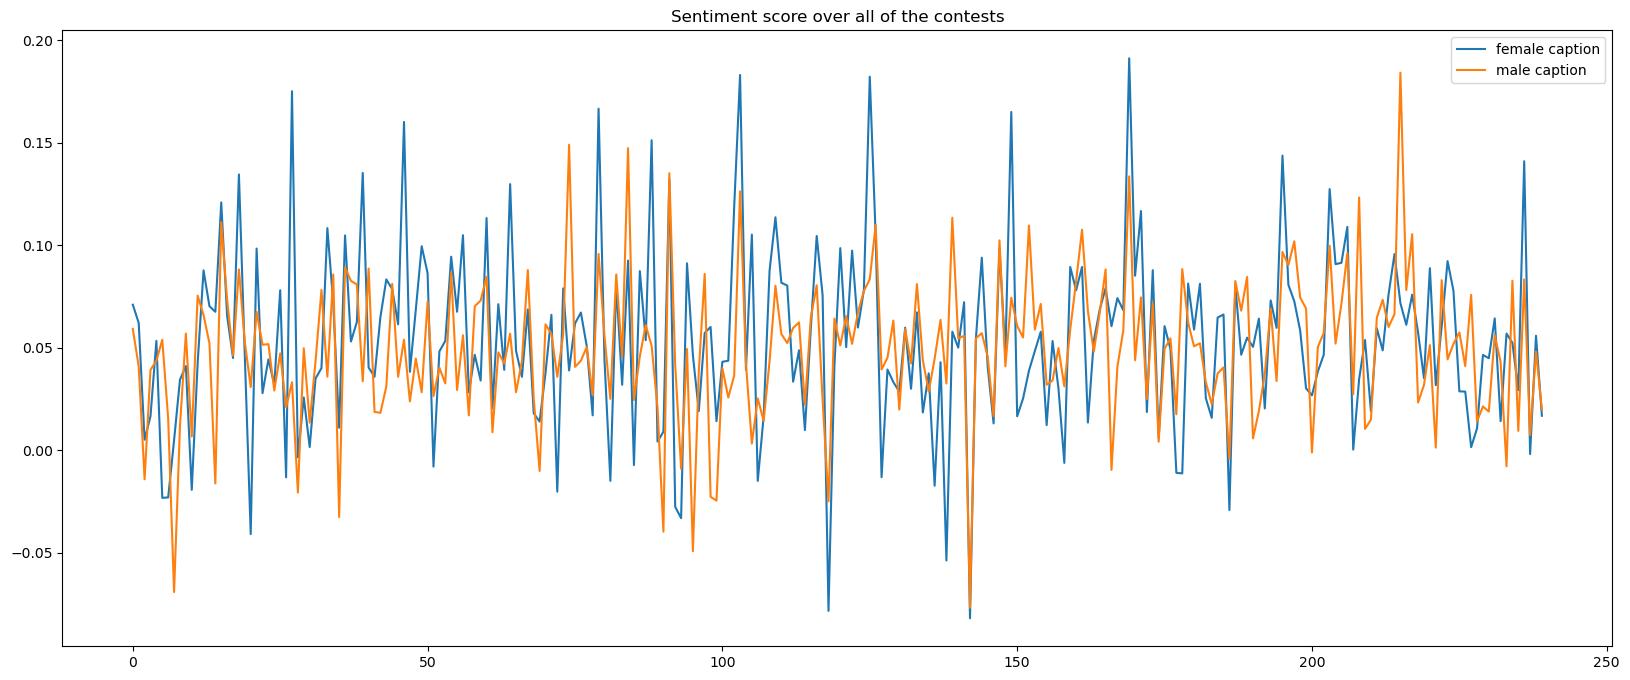

In [123]:
### --- PLOTS ---
plt.figure(figsize=(20,8))
plt.title("Sentiment score over all of the contests")
plt.plot(mean_sent_female, label = 'female caption')
plt.plot(mean_sent_male, label = 'male caption')
plt.legend()

#### For each topic

In [22]:
sia = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    return sia.polarity_scores(text)["compound"]

# Apply to each dataframe
df_topics_male["sentiment"] = df_topics_male["caption"].apply(compute_sentiment)
df_topics_female["sentiment"] = df_topics_female["caption"].apply(compute_sentiment)

# Add gender label
df_topics_male["gender_label"] = "male"
df_topics_female["gender_label"] = "female"


In [23]:
df = pd.concat([df_topics_male, df_topics_female], ignore_index=True)
avg_sentiment = (
    df.groupby(["aggregated_theme", "gender_label"])["sentiment"]
      .mean()
      .reset_index()
)

In [28]:
themes_male = set(df_topics_male["aggregated_theme"].dropna().unique())
themes_female = set(df_topics_female["aggregated_theme"].dropna().unique())

common_themes = themes_male.intersection(themes_female)
df_common = df[df["aggregated_theme"].isin(common_themes)]

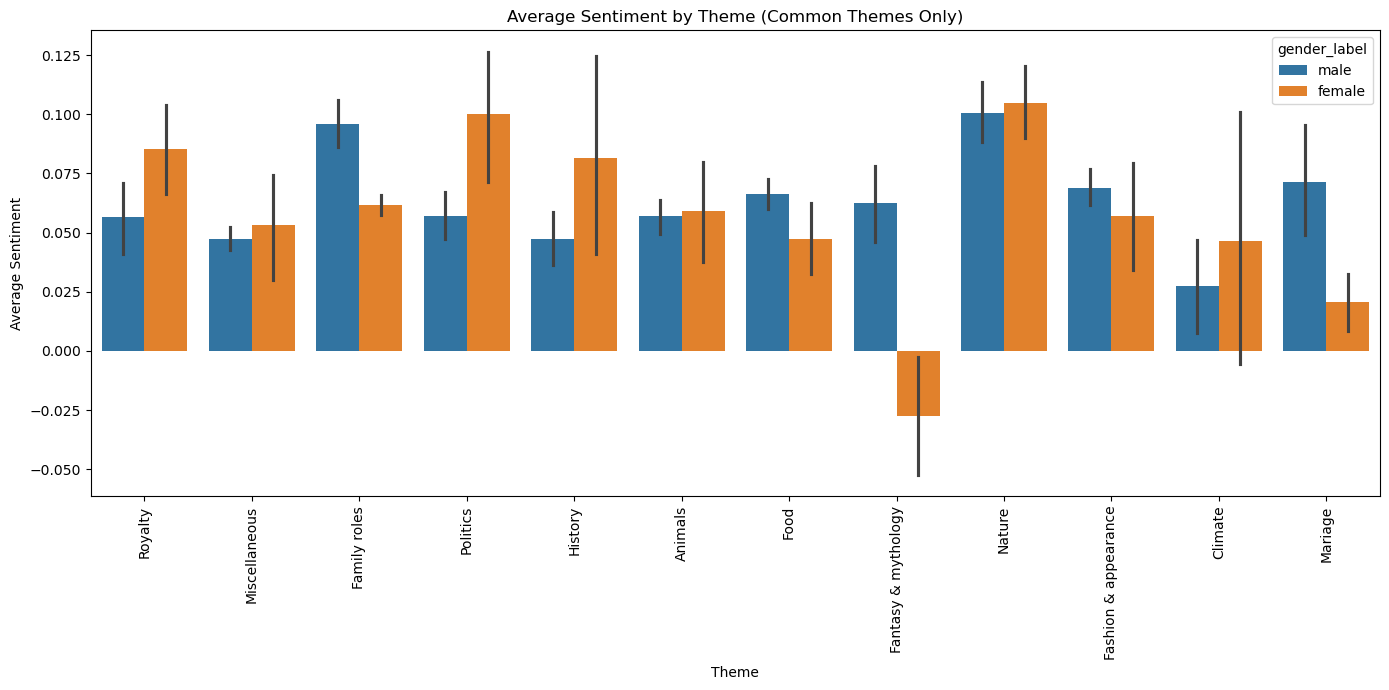

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_common,
    x="aggregated_theme",
    y="sentiment",
    hue="gender_label",
    estimator="mean",     # default, but explicit is clearer
    errorbar=("ci", 95),  # show 95% confidence intervals
)

plt.xticks(rotation=90)
plt.title("Average Sentiment by Theme (Common Themes Only)")
plt.ylabel("Average Sentiment")
plt.xlabel("Theme")
plt.tight_layout()
plt.show()


#### Notes for me

🧪 Why p-values, effect sizes, and multiple testing exist (explained badly but memorably)

Imagine you’re digging for gold.

If you dig one hole and find gold → wow! 🎉

If you dig 50 holes, one of them will look shiny by accident 🪨✨

👉 Multiple-testing correction is your friend tapping your shoulder saying:

“Hey… maybe that’s just a shiny rock.”

Now imagine you did find gold.

If it’s a mountain of gold → amazing 💰💰💰

If it’s one glittery grain → technically gold… but who cares 😐

👉 Effect size answers:

“Is this treasure or just sparkly dust?”

And the p-value?

The p-value only asks:

“Are we sure this isn’t imaginary?”

It does not ask:

Is it big?

Is it useful?

Should I tell my friends?

🧠 Final wisdom for future me

Many tests → fake surprises → correct for them

Tiny differences → fake importance → report effect sizes

p < 0.05 alone → lies politely

Or in one sentence:

“Statistical significance tells me it’s real.
Effect size tells me it matters.
Correction tells me I’m not fooling myself.”

Think of it like this:

p-value = “Are we sure this difference exists?”

Effect size = “Do we care?”

And:

Multiple testing correction = “Are we fooling ourselves by looking too much?”

#### Statistical testing (topic)

For each aggregated theme:

H₀ (null):
Mean sentiment (male) = Mean sentiment (female)

H₁ (alternative):
Mean sentiment (male) ≠ Mean sentiment (female)

In [30]:
results = []

for theme in common_themes:
    male_vals = df_common[
        (df_common["aggregated_theme"] == theme) &
        (df_common["gender_label"] == "male")
    ]["sentiment"]

    female_vals = df_common[
        (df_common["aggregated_theme"] == theme) &
        (df_common["gender_label"] == "female")
    ]["sentiment"]

    # Safety check
    if len(male_vals) < 10 or len(female_vals) < 10:
        continue

    stat, p = mannwhitneyu(
        male_vals,
        female_vals,
        alternative="two-sided"
    )

    results.append({
        "theme": theme,
        "n_male": len(male_vals),
        "n_female": len(female_vals),
        "mean_male": male_vals.mean(),
        "mean_female": female_vals.mean(),
        "p_value": p
    })
df_tests = pd.DataFrame(results).sort_values("p_value")
df_tests


,theme,n_male,n_female,mean_male,mean_female,p_value
8,Family roles,4568,20224,0.095906,0.061668,3.288786e-10
2,Fantasy & mythology,1461,916,0.062394,-0.027407,2.537623e-08
5,Mariage,701,2493,0.071457,0.020772,4.173151e-04
9,Politics,3706,614,0.057154,0.100210,5.422585e-03
6,Royalty,2020,1140,0.056361,0.085285,3.487673e-02
1,History,2283,174,0.047118,0.081418,2.990802e-01
0,Food,10703,1690,0.066213,0.047351,3.713451e-01
10,Fashion & appearance,6698,742,0.068984,0.056950,4.462464e-01
11,Climate,1237,167,0.027533,0.046405,6.750774e-01
7,Animals,7977,849,0.056813,0.059258,8.424215e-01


In [32]:
from statsmodels.stats.multitest import multipletests

# multiple-testing corrections

# Extract p-values
pvals = df_tests["p_value"].values

# Apply Benjamini–Hochberg FDR correction
reject, pvals_corrected, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="fdr_bh"
)

# Add results back to the DataFrame
df_tests["p_value_fdr"] = pvals_corrected
df_tests["significant_fdr"] = reject


In [33]:
df_tests

,theme,n_male,n_female,mean_male,mean_female,p_value,p_value_fdr,significant_fdr
8,Family roles,4568,20224,0.095906,0.061668,3.288786e-10,3.946543e-09,True
2,Fantasy & mythology,1461,916,0.062394,-0.027407,2.537623e-08,1.522574e-07,True
5,Mariage,701,2493,0.071457,0.020772,4.173151e-04,1.669260e-03,True
9,Politics,3706,614,0.057154,0.100210,5.422585e-03,1.626775e-02,True
6,Royalty,2020,1140,0.056361,0.085285,3.487673e-02,8.370414e-02,False
1,History,2283,174,0.047118,0.081418,2.990802e-01,5.981603e-01,False
0,Food,10703,1690,0.066213,0.047351,3.713451e-01,6.365917e-01,False
10,Fashion & appearance,6698,742,0.068984,0.056950,4.462464e-01,6.693696e-01,False
11,Climate,1237,167,0.027533,0.046405,6.750774e-01,9.001032e-01,False
7,Animals,7977,849,0.056813,0.059258,8.424215e-01,9.947700e-01,False


**EFFECT SIZE**

1️⃣ What is Cliff’s delta (intuitively)

Cliff’s delta answers this question:

If I randomly pick one male caption and one female caption,
how often is one sentiment higher than the other?

Its range is:

-1  ← females always higher
 0  ← no difference
+1  ← males always higher


Rules of thumb for interpretation:

| |δ| | Interpretation |
|---|---|
| < 0.147 | negligible |
| < 0.33 | small |
| < 0.474 | medium |
| ≥ 0.474 | large |

This is distribution-free, so it matches Mann–Whitney perfectly.

In [34]:
def cliffs_delta(x, y):
    """
    Compute Cliff's delta effect size.
    x, y: arrays or lists
    """
    x = np.asarray(x)
    y = np.asarray(y)

    nx = len(x)
    ny = len(y)

    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)

    return (greater - less) / (nx * ny)


In [35]:
effect_sizes = []

for theme in df_tests["theme"]:
    male_vals = df_topics_male.loc[
        df_topics_male["aggregated_theme"] == theme, "sentiment"
    ].dropna()

    female_vals = df_topics_female.loc[
        df_topics_female["aggregated_theme"] == theme, "sentiment"
    ].dropna()

    if len(male_vals) > 0 and len(female_vals) > 0:
        delta = cliffs_delta(male_vals, female_vals)
    else:
        delta = np.nan

    effect_sizes.append(delta)

df_tests["cliffs_delta"] = effect_sizes


In [36]:
def interpret_delta(delta):
    if pd.isna(delta):
        return "NA"
    abs_d = abs(delta)
    if abs_d < 0.147:
        return "negligible"
    elif abs_d < 0.33:
        return "small"
    elif abs_d < 0.474:
        return "medium"
    else:
        return "large"

df_tests["effect_size"] = df_tests["cliffs_delta"].apply(interpret_delta)
df_tests


,theme,n_male,n_female,mean_male,mean_female,p_value,p_value_fdr,significant_fdr,cliffs_delta,effect_size
8,Family roles,4568,20224,0.095906,0.061668,3.288786e-10,3.946543e-09,True,0.056206,negligible
2,Fantasy & mythology,1461,916,0.062394,-0.027407,2.537623e-08,1.522574e-07,True,0.129439,negligible
5,Mariage,701,2493,0.071457,0.020772,4.173151e-04,1.669260e-03,True,0.081809,negligible
9,Politics,3706,614,0.057154,0.100210,5.422585e-03,1.626775e-02,True,-0.066300,negligible
6,Royalty,2020,1140,0.056361,0.085285,3.487673e-02,8.370414e-02,False,-0.043326,negligible
1,History,2283,174,0.047118,0.081418,2.990802e-01,5.981603e-01,False,-0.042750,negligible
0,Food,10703,1690,0.066213,0.047351,3.713451e-01,6.365917e-01,False,0.012954,negligible
10,Fashion & appearance,6698,742,0.068984,0.056950,4.462464e-01,6.693696e-01,False,0.016314,negligible
11,Climate,1237,167,0.027533,0.046405,6.750774e-01,9.001032e-01,False,-0.019687,negligible
7,Animals,7977,849,0.056813,0.059258,8.424215e-01,9.947700e-01,False,-0.003982,negligible


Despite a substantial imbalance in sample sizes favoring male-labeled captions, observed gender differences in sentiment remain negligible across themes.

#### Statistical testing (all)

First visualize the distribution to pick an appropriate test.

In [41]:
len(all_sentiment_female)

240

In [42]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

list_all_sentiment_female = flatten(all_sentiment_female)
list_all_sentiment_male = flatten(all_sentiment_male)

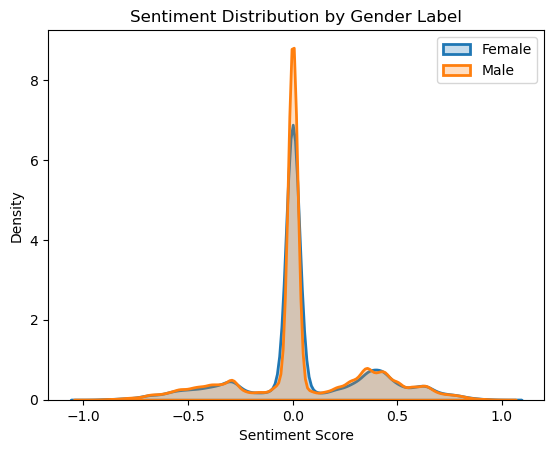

In [43]:
sns.kdeplot(list_all_sentiment_female, fill=True, label = 'Female', linewidth=2)
sns.kdeplot(list_all_sentiment_male, fill=True, label="Male", linewidth=2)

plt.title("Sentiment Distribution by Gender Label")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

Null hypothesis H₀:

There is no significant difference in sentiment score between male and female captions.

Decision rule:

If p-value < 0.05 → reject H₀ → sentiment differs between male and female captions

If p-value ≥ 0.05 → fail to reject H₀ → no evidence of difference

In [44]:
u_stat, p_value = mannwhitneyu(list_all_sentiment_female, list_all_sentiment_male, alternative="two-sided")
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

Mann-Whitney U: 12906225285.0
p-value: 0.44118922622203616


## Step 3: How does audience response relate to gendered content ? 

In [17]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [19]:
# Creating two dataframes with all the men and women labelled captions

caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

for idx, contest in enumerate(data_caption[1:]):
    
    male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
    frames = [caption_male_df, male_caps]
    caption_male_df = pd.concat(frames)

    female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
    frames_ = [caption_female_df, female_caps]
    caption_female_df = pd.concat(frames_)

# Save DataFrame to CSV
caption_female_df.to_csv(r'src\all_caption_female_1.csv', index=False)
caption_male_df.to_csv(r'src\all_caption_male_1.csv', index=False)

### Plots

In [20]:
# mean + std score over contest
mean_funny_female = []
std_funny_female = []
list_funny_female = []

for contest in data_caption:
    fem = contest[contest['gender_mention'] == 'female']
    mean_funny_female.append(fem['funny_score'].mean())
    std_funny_female.append(fem['funny_score'].std())
    list_funny_female.append(fem['funny_score'].values)

In [21]:
mean_funny_male = []
std_funny_male = []
list_funny_male = []

for contest in data_caption:
    male = contest[contest['gender_mention'] == 'male']
    mean_funny_male.append(male['funny_score'].mean())
    std_funny_male.append(male['funny_score'].std())
    list_funny_male.append(male['funny_score'].values)

# !!!! SAVE RESULTS PICKLE !!!

Text(0.5, 1.0, 'Funiness score for female caption over all contests')

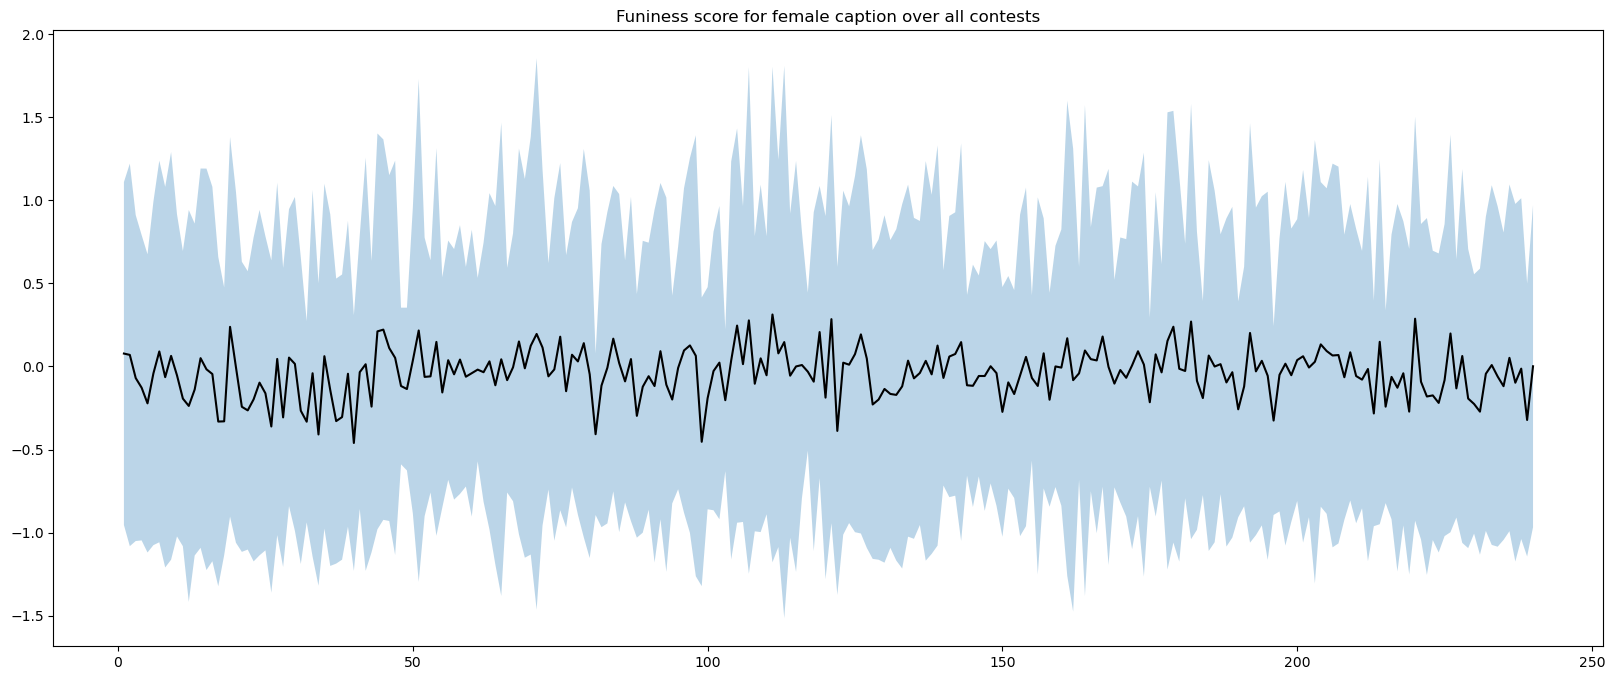

In [121]:
plt.figure(figsize=(20,8))
plt.fill_between(x=np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], y1=np.array(mean_funny_female)+np.array(std_funny_female), y2=np.array(mean_funny_female)-np.array(std_funny_female),
                 alpha = 0.3, linestyle = '--')
plt.plot(np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], mean_funny_female, color = 'black')
plt.title("Funiness score for female caption over all contests")

Text(0.5, 1.0, 'Funiness score for male caption over all contests')

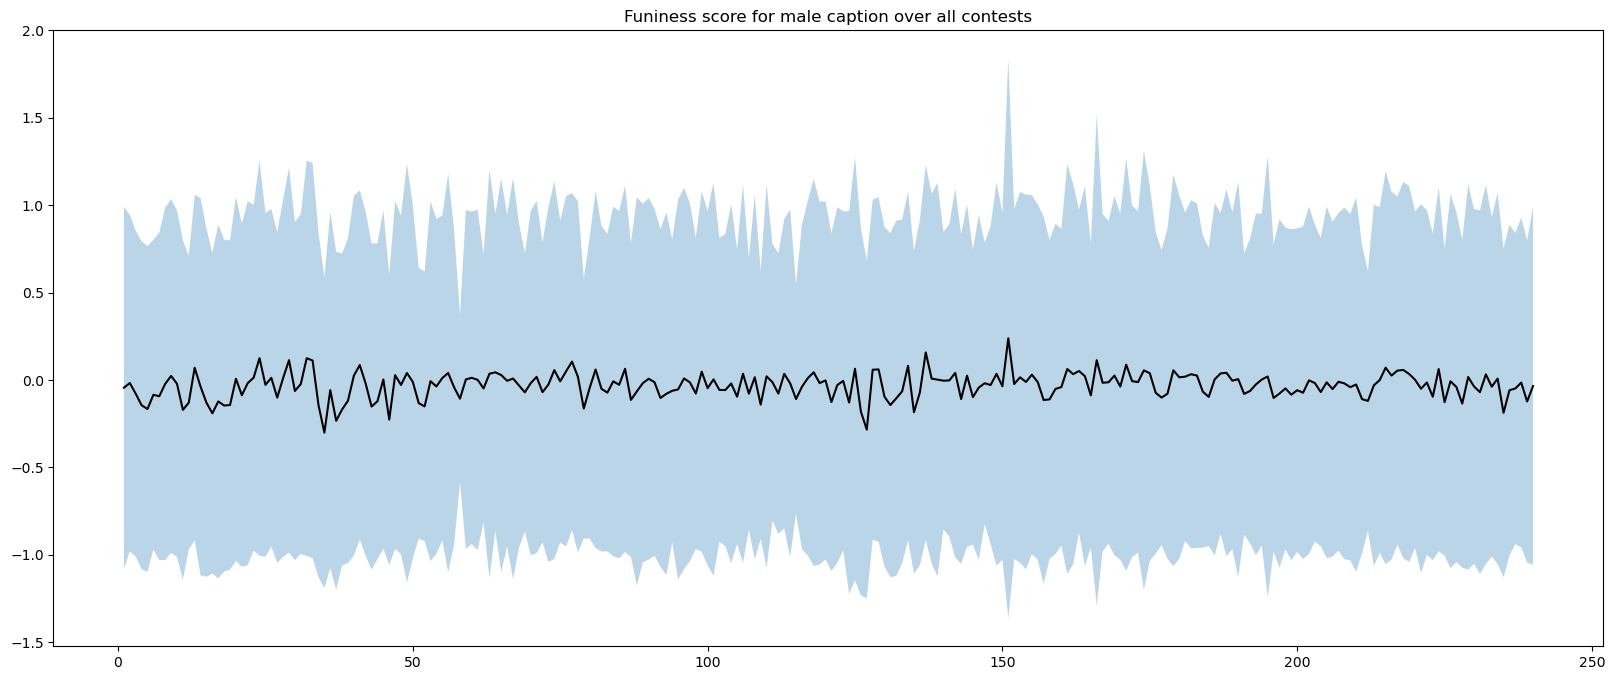

In [158]:
plt.figure(figsize=(20,8))
plt.fill_between(x=np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], y1=np.array(mean_funny_male)+np.array(std_funny_male), y2=np.array(mean_funny_male)-np.array(std_funny_male),
                 alpha = 0.3, linestyle = '--')
plt.plot(np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], mean_funny_male, color = 'black')
plt.title("Funiness score for male caption over all contests")

In [25]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [26]:
flatten_funny_male = flatten(list_funny_male)
flatten_funny_female = flatten(list_funny_female)

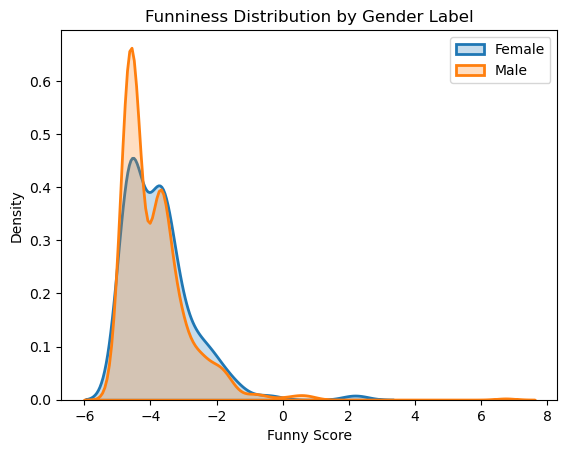

In [27]:
sns.kdeplot(flatten_funny_female[0], fill=True, label = 'Female', linewidth=2)
sns.kdeplot(flatten_funny_male[0], fill=True, label="Male", linewidth=2)

plt.title("Funniness Distribution by Gender Label")
plt.xlabel("Funny Score")
plt.legend()
plt.show()

Since the values of the funiness score vary a lot for each contest, we'll use statistical testing.

### Statistical testing

ADD TESTING TO SEE IF IT'S MORE FUNNY TO WRITE GENDERED CAPTIONS IN GENERAL !!
ALSO PLOT DISTRIBUTIONS

In [30]:
u_stat, p_value = mannwhitneyu(flatten_funny_female[0], flatten_funny_male[0], alternative="two-sided")
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

Mann-Whitney U: 39666.5
p-value: 0.09654745396792908


## Other codes

In [ ]:
def plot_topic(df_topics, gender):
    theme_counts = df_topics["aggregated_theme"].value_counts().sort_values(ascending=False)
    total_captions = theme_counts.sum()
    theme_percent = (theme_counts / total_captions) * 100

    circle_data = []

    for theme in theme_counts.index:
        theme_size = theme_counts[theme]

        circle_data.append(dict(
            id=theme,
            parent="",
            value=theme_size,
            percent=theme_percent[theme]
        ))

    df_circles = pd.DataFrame(circle_data)

    fig = px.treemap(
        df_circles,
        names="id",
        parents="parent",
        values="value",
        color="id",
        color_discrete_sequence=px.colors.qualitative.Set3,
        title=f"Themes in {gender} labeled captions",
        custom_data=["percent"]
    )

    fig.update_traces(root_color="lightgrey")

    fig.update_traces(
    hovertemplate="<b>%{label}</b><br>" +
                  "Count: %{value}<br>" +
                  "Percent: %{customdata[0]:.2f}%<extra></extra>"
    )

    fig.show()

    return fig

In [23]:
male_terms = [
            'guy', 'spokesman', 'chairman', "men's", 'men', 'him', "he's", 'his', 'boy',
            'boyfriend', 'boyfriends', 'boys', 'brother', 'brothers', 'dad', 'dads',
            'dude', 'father', 'fathers', 'fiance', 'gentleman', 'gentlemen', 'god',
            'grandfather', 'grandpa', 'grandson', 'groom', 'he', 'himself', 'husband',
            'husbands', 'king', 'male', 'man', 'mr', 'nephew', 'nephews', 'priest',
            'prince', 'son', 'sons', 'uncle', 'uncles', 'waiter', 'widower', 'widowers',
            'congressman',

            # --- Added universal & contextual male terms ---
            'bloke', 'chap', 'fella', 'gent', 'sir', 'lad', 'lads',
            'manliness', 'masculine', 'boyhood',
            'father-in-law', 'stepfather', 'stepson',
            'godfather', 'old man',
            'bachelor', 'groomsman',
            'kings',
            'monk', 'wizard',
            'policeman', 'fireman', 'salesman', 'businessman', 'workman',

            # --- Public figures ---
            "bush", "sanders",
            "einstein", "hitchcock", "bansky", "kanye", "obama","biden","trump","putin","zelenskyy",
            "macron","schwarzenegger","clooney","hanks","dicaprio",
            "pitt","depp","cruise","stallone","eastwood","gosling","carey","seinfeld","rock","chappelle",
            "sandler","springsteen","dylan","cobain","mars","drake","sheeran","mccartney","lennon",
            "jagger","bale","damon","affleck","reynolds","washington","freeman","jackson","smith","murphy",
            "reeves","keaton","downey","ruffalo","leno","colbert","stewart","oppenheimer","gates","musk"


            # --- 200 Most Popular American male names ---
            "james","robert","john","michael","david","william","richard","joseph","thomas","charles",
            "christopher","daniel","matthew","anthony","mark","donald","steven","paul","andrew","joshua",
            "kenneth","kevin","brian","george","edward","ronald","timothy","jason","jeffrey","ryan",
            "jacob","gary","nicholas","eric","jonathan","stephen","larry","justin","scott","brandon",
            "benjamin","samuel","gregory","alexander","frank","patrick","raymond","jack","dennis","jerry",
            "tyler","aaron","jose","adam","nathan","henry","douglas","zachary","peter","kyle",
            "walter","ethan","jeremy","harold","keith","christian","roger","noah","gerald","carl",
            "terry","sean","austin","arthur","lawrence","jesse","dylan","bryan","joe","jordan",
            "billy","bruce","albert","willie","gabriel","logan","alan","juan","wayne","roy",
            "ralph","randy","eugene","vincent","bobby","russell","louis","philip","johnny","riley",
            "victor","mason","dale","brett","caleb","curtis","phillip","nathaniel","rodney","cody",
            "joel","craig","tony","evan","shawn","wesley","alex","travis","chad","derrick",
            "stanley","leonard","connor","oscar","xavier","miguel","edwin","martin","emmanuel","jay",
            "clifford","herman","seth","edgar","mario","frederick","allen","tyrone","max","aiden",
            "colton","hector","jon","spencer","rick","clarence","malik","leo","dustin","maurice",
            "dominic","hayden","troy","gordon","marshall","abel","andre","lawson","reed","ramon",
            "lance","casey","terrence","francis","trevor","jared","marco","darren","eli","ben",
            "rafael","don","diego","romeo","ruben","clayton","carlos","kirk","brayden","ronnie",
            "felix","jimmy","asher","camden","harvey","brendan","tristan","dean","parker","francisco",
            "ivan","milo","ted"
        ]

In [21]:
dataA[0]['caption'][3901]

"This has 'Alice in Wonderland' beat by a mile."

In [15]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
example = data_caption[0]['caption'].values[0]
example

"i'm a congressman--obstruction is my job."

In [21]:
example = data_caption[0]['caption'].values[0]
doc = nlp(example)

In [24]:
tokens = [token.text for token in doc]
print(tokens)

['This', 'has', "'", 'Alice', 'in', 'Wonderland', "'", 'beat', 'by', 'a', 'mile', '.']


In [25]:
pos_tagged = [(token.text, token.pos_) for token in doc]
print(pos_tagged)

[('This', 'PRON'), ('has', 'VERB'), ("'", 'PUNCT'), ('Alice', 'PROPN'), ('in', 'ADP'), ('Wonderland', 'PROPN'), ("'", 'PUNCT'), ('beat', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('mile', 'NOUN'), ('.', 'PUNCT')]


In [26]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Alice PERSON
Wonderland GPE
a mile QUANTITY


In [ ]:
def extract_nouns(dataA):
    nlp = spacy.load("en_core_web_sm")
    nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

    for text in captions:
        doc = nlp(text)
        for token in doc:
            if token.pos_ in ["NOUN"]:  # common + proper nouns
                nouns[token.lemma_] += 1
    return nouns

def extract_proper_nouns(dataA):

    nlp = spacy.load("en_core_web_sm")
    proper_nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

        for text in captions:
            doc = nlp(text)
            for ent in doc.ents:
                if ent.label_ == 'PERSON':
                    proper_nouns[ent.text] += 1

    return proper_nouns

In [61]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

verbs_male = []
verbs_female = []
adjs_male = []
adjs_female = []

# Create two separated document: one with all the male and the other with all of the female captions
for contest in data_caption:
    # initialize lists that keep track of type of words
    verb_male = []
    verb_female = []
    adj_male = []
    adj_female = []


    # find in each caption that are labeled as male the verb and ajdectives
    male_captions = contest[contest['gender_mention'] == 'male'].caption.values
    for caption in male_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_male.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_male.append(token.text)


    # find in each caption that are labeled as female the verb and ajdectives
    female_captions = contest[contest['gender_mention'] == 'female'].caption.values
    for caption in female_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_female.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_female.append(token.text)

    
    verbs_male.append(verb_male)
    verbs_female.append(verb_female)
    adjs_male.append(adj_male)
    adjs_female.append(adj_female)
    break

In [ ]:
## LDA Model -> UNSTABLE    

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import re

# Download NLTK stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')

# Load data
data = pd.read_csv('all_caption_female.csv')

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text

# Tokenize and remove stopwords
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

data['cleaned_text'] = data['caption'].apply(preprocess_text) 
data['tokens'] = data['cleaned_text'].apply(tokenize)

# Lemmatization using spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data['lemmas'] = data['tokens'].apply(lemmatize)

# Create dictionary and corpus
id2word = corpora.Dictionary(data['lemmas'])
texts = data['lemmas']
corpus = [id2word.doc2bow(text) for text in texts]

Number of topics: 6.0
Number of topics: 7.0
Number of topics: 8.0
Number of topics: 9.0
Number of topics: 10.0
Number of topics: 11.0
Number of topics: 12.0
Number of topics: 13.0
Number of topics: 14.0
Number of topics: 15.0
Number of topics: 16.0
Number of topics: 17.0
Number of topics: 18.0
Number of topics: 19.0
Number of topics: 20.0


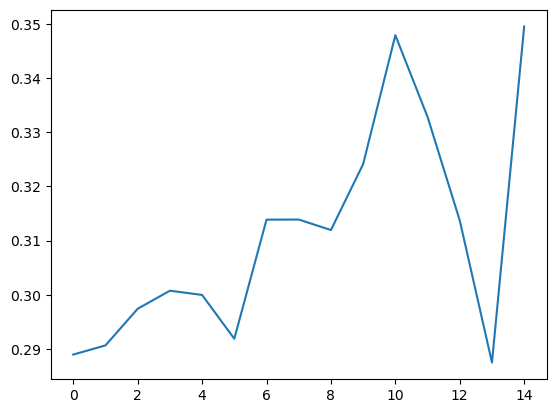

In [ ]:
num_topics_list = np.linspace(6, 20, 15)

coherence_score = []

for i in num_topics_list:
    print(f"Number of topics: {i}")
    # Build LDA model, NUMBER OF TOPICS: pick the one that has the highest coherence score.
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=i, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    # Print the topics
    # topics = lda_model.print_topics(num_words=5)
    # for topic in topics:
    #     print(topic)

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemmas'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

plt.plot(coherence_score)

In [59]:
# ## From the exercices

# analyzer = SentimentIntensityAnalyzer()
# vs = analyzer.polarity_scores(example)

# print(example, '\n')
# print('Negative sentiment:',vs['neg'])
# print('Neutral sentiment:',vs['neu'])
# print('Positive sentiment:',vs['pos'])
# print('Compound sentiment:',vs['compound'])

# nlp = spacy.load('en_core_web_sm')
# doc = nlp(books[3])

# positive_sent = []
# #iterate through the sentences, get polarity scores, choose a value
# [positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
# plt.hist(positive_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Positive sentiment')
# plt.ylabel('Number of sentences')

# negative_sent = []
# [negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
# plt.hist(negative_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Negative sentiment')
# plt.ylabel('Number of sentences')

# total_sent = []
# [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
# plt.hist(total_sent,bins = 15)
# plt.xlim([-1,1])
# plt.ylim([0,8000])
# plt.xlabel('Compound sentiment')
# plt.ylabel('Number of sentences')

# sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
# print('Number of positive sentences:',sum(np.array(sents)>=0.05))
# print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
# print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))